In [1]:
import numpy as np
import dask.array as da

In [16]:
np_arr = np.random.randint(20, size=19)
np_arr

array([12,  8, 18, 14,  9, 15,  4,  0, 17,  5,  9, 12,  9,  6, 16,  8, 15,
       14, 14])

### 要使用Dask Array, 只需在後面多加一項`chunks`

In [17]:
dask_arr = da.random.randint(20, size=19, chunks=5)

### Dask使用 lazy evaluation，因此不會直接出現結果

In [18]:
dask_arr

dask.array<randint, shape=(19,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

### 需要使用 `compute()` 來呈現運算結果

In [19]:
dask_arr.compute()

array([ 0,  3, 10, 12,  2, 12, 13, 14,  1,  4,  4,  2,  7,  6,  1,  8,  3,
       14, 10])

### Chunks size 

In [20]:
dask_arr.chunks

((5, 5, 5, 4),)

### 將np_arr轉為dask_arr

In [21]:
dask_arr_from_np = da.from_array(np_arr, chunks=5)

In [22]:
dask_arr_from_np

dask.array<array, shape=(19,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

In [28]:
dask_arr_from_np.compute()

array([12,  8, 18, 14,  9, 15,  4,  0, 17,  5,  9, 12,  9,  6, 16,  8, 15,
       14, 14])

## Dask 可以先將運算流程圖呈現

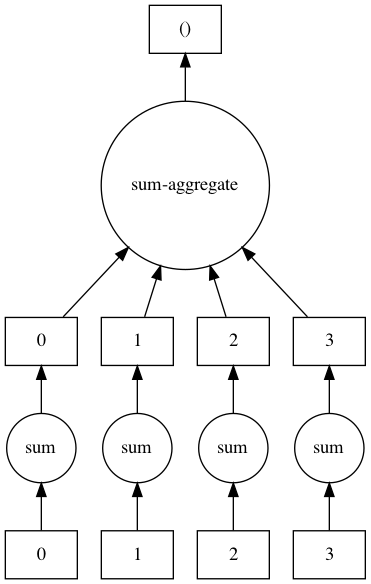

In [24]:
dask_arr_from_np.sum().visualize()

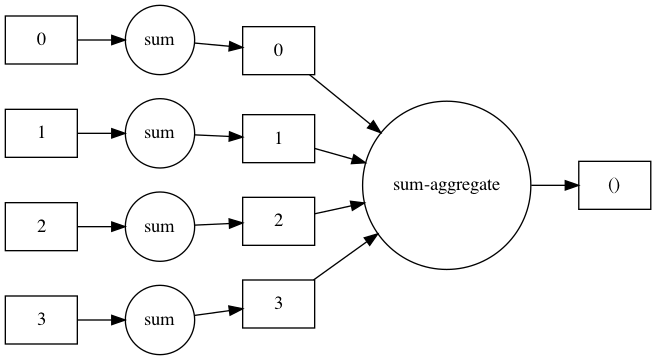

In [25]:
dask_arr_from_np.sum().visualize(rankdir="LR")

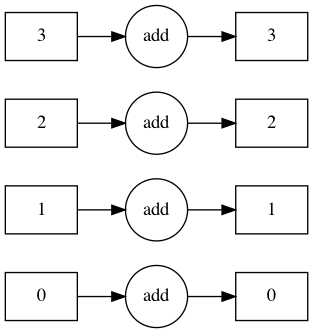

In [31]:
(dask_arr_from_np+1).visualize(rankdir="LR")

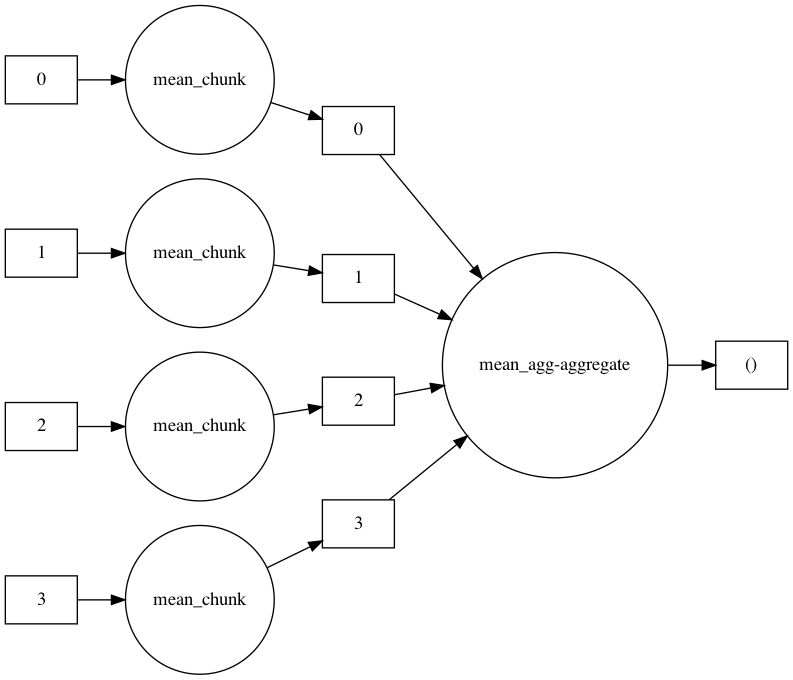

In [34]:
dask_arr_mean = da.mean(dask_arr_from_np)
dask_arr_mean.visualize(rankdir="LR")

## Another Example

In [35]:
x = da.random.random(10, chunks=2)
y = da.random.random(10, chunks=2)

sum_x_y = da.add(x, y) #與 numpy.add 相似
mean_x_y = da.mean(sum_x_y)

In [36]:
sum_x_y.compute()

array([1.45922553, 0.82531098, 1.43647265, 1.36347398, 0.419373  ,
       0.77850644, 1.79092051, 1.14055544, 0.94507729, 0.6146983 ])

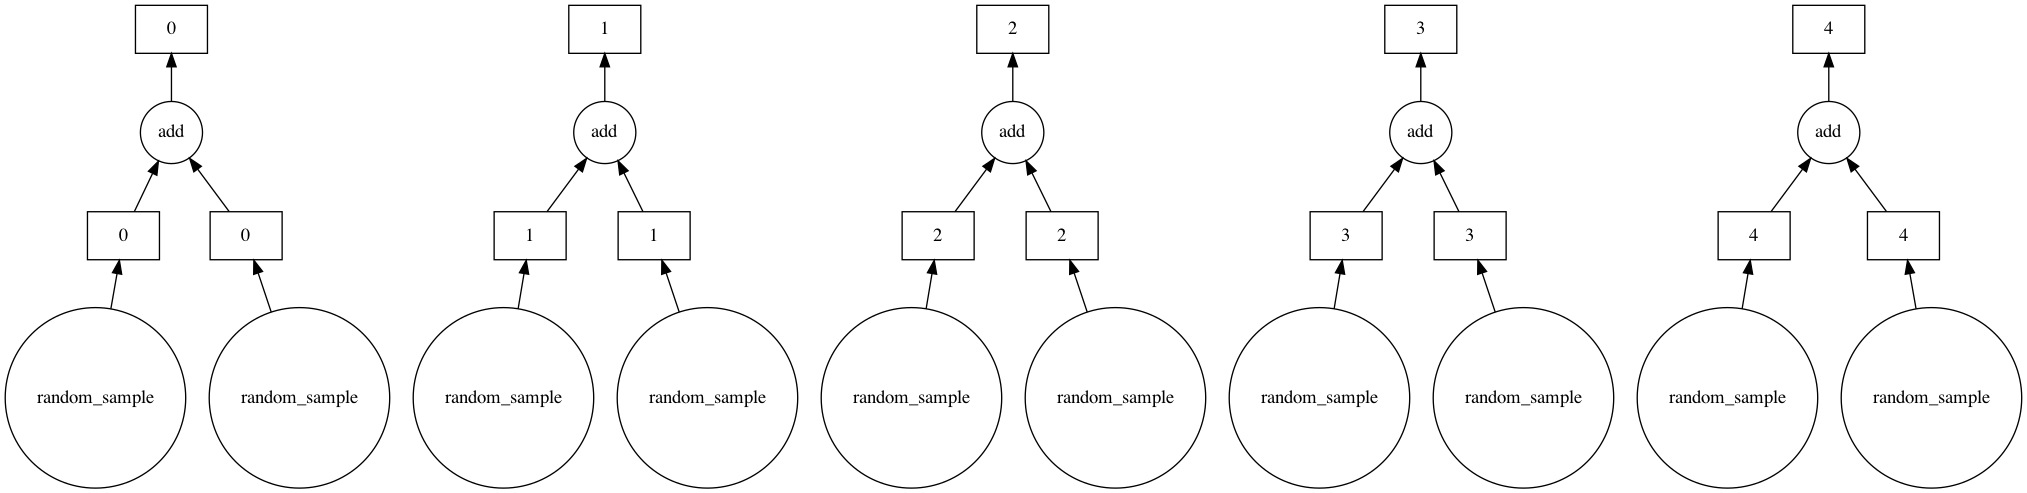

In [37]:
sum_x_y.visualize()

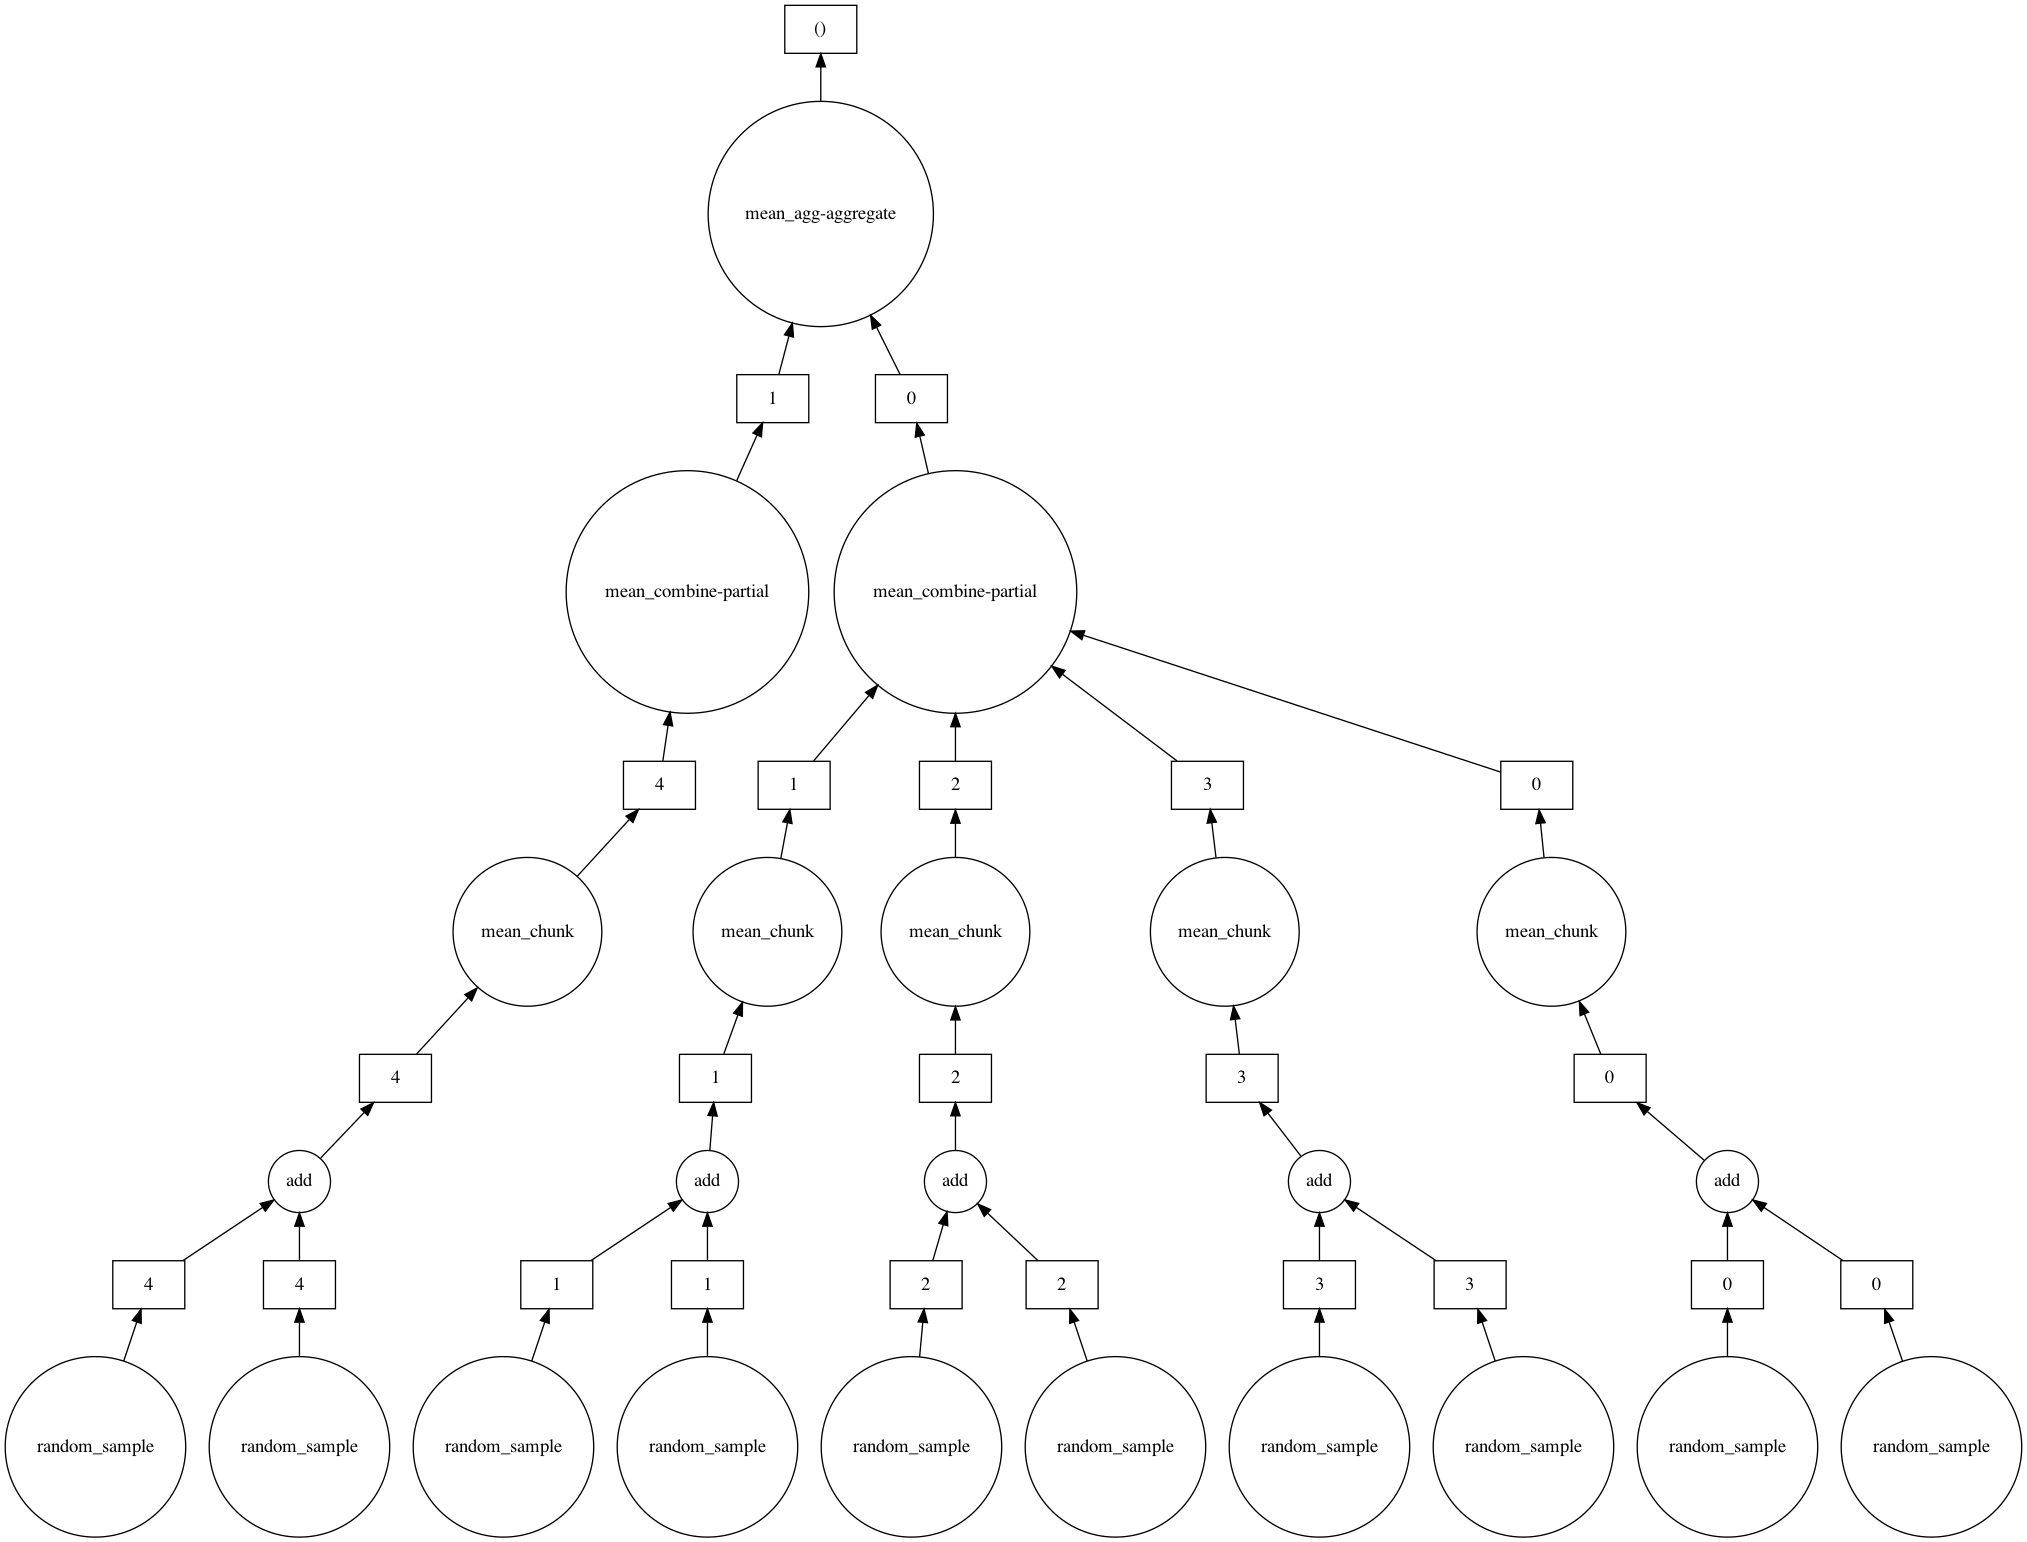

In [38]:
mean_x_y.visualize()

### 使用NumPy運算之效率

In [39]:
size_tuple = (18000,18000)
np_arr = np.random.randint(10, size=size_tuple)
np_arr2 = np.random.randint(10, size=size_tuple)

In [40]:
%time (((np_arr * 2).T)**2 + np_arr2 + 100).sum(axis=1).mean()

CPU times: user 6.18 s, sys: 4.77 s, total: 10.9 s
Wall time: 12 s


3932835.3788888888

### 使用Dask運算之效率

In [41]:
chunks_tuple = (500, 500)
da_arr = da.from_array(np_arr, chunks=chunks_tuple)
da_arr2 = da.from_array(np_arr2, chunks=chunks_tuple)

In [42]:
%time (((da_arr * 2).T)**2 + da_arr2 + 100).sum(axis=1).mean().compute()

CPU times: user 7.71 s, sys: 595 ms, total: 8.31 s
Wall time: 1.32 s


3932835.3788888888

## 範例:記憶體不足的運算

### NumPy 無法載入大量數據

In [2]:
size_tuple = (50000, 50000)
np_arr = np.random.randint(10, size=size_tuple)
np_arr2 = np.random.randint(10, size=size_tuple)

# you might have to KeyboardInterrupt this part of code since numpy cannot handle this amount of data

KeyboardInterrupt: 

### Dask可以

In [43]:
size_tuple = (50000, 50000)
chunks_tuple = (5000, 5000)
da_arr = da.random.randint(10, size=size_tuple,
                           chunks=chunks_tuple)
da_arr2 = da.random.randint(10, size=size_tuple,
                            chunks=chunks_tuple)

In [44]:
%time (((da_arr * 2).T)**2 + da_arr2 + 100).sum(axis=1).mean().compute()

CPU times: user 2min 58s, sys: 47.3 s, total: 3min 45s
Wall time: 25.6 s


10924978.80488

In [45]:
da_arr.nbytes

20000000000

### Bytes 轉為 GB, 1Gb = 1e+9 bytes

In [46]:
da_arr.nbytes/1e+9

20.0

# dask.delayed

### 正常情況下

In [140]:
x = [2, 4, 6, 8, 10]
y = [3, 6, 9, 12, 15]
z = [10, 20, 30, 40, 50]

In [141]:
from time import sleep

def do_something_1(x, y):
    sleep(1)
    return x + y + 2*x*y

def do_something_2(a, b):
    sleep(1)
    return a**3 - b**3

def do_something_3(p, q):
    sleep(1)
    return p*p + q*q

In [142]:
%%time

final_result = []
for i in range(0, len(x)):
    res_1 = do_something_1(x[i], y[i])
    res_2 = do_something_2(y[i], z[i])
    res_3 = do_something_3(res_1, res_2)
    final_result.append(res_3)

sum_arr = sum(final_result)

CPU times: user 1.15 ms, sys: 1.13 ms, total: 2.28 ms
Wall time: 15.1 s


### 使用dask.delayed

In [171]:
from dask import delayed
import dask

In [172]:
@delayed
def do_something_1(x, y):
    sleep(1)
    return x + y + 2*x*y

@delayed
def do_something_2(a, b):
    sleep(1)
    return a**3 - b**3

@delayed
def do_something_3(p, q):
    sleep(1)
    return p*p + q*q

In [173]:
%%time

final_result = []
for i in range(0, len(x)):
    res_1 = do_something_1(x[i], y[i])
    res_2 = do_something_2(y[i], z[i])
    res_3 = do_something_3(res_1, res_2)
    final_result.append(res_3)

final_sum = sum(final_result)

final_sum.compute()

CPU times: user 4.71 ms, sys: 2.91 ms, total: 7.62 ms
Wall time: 2.01 s


19422314786

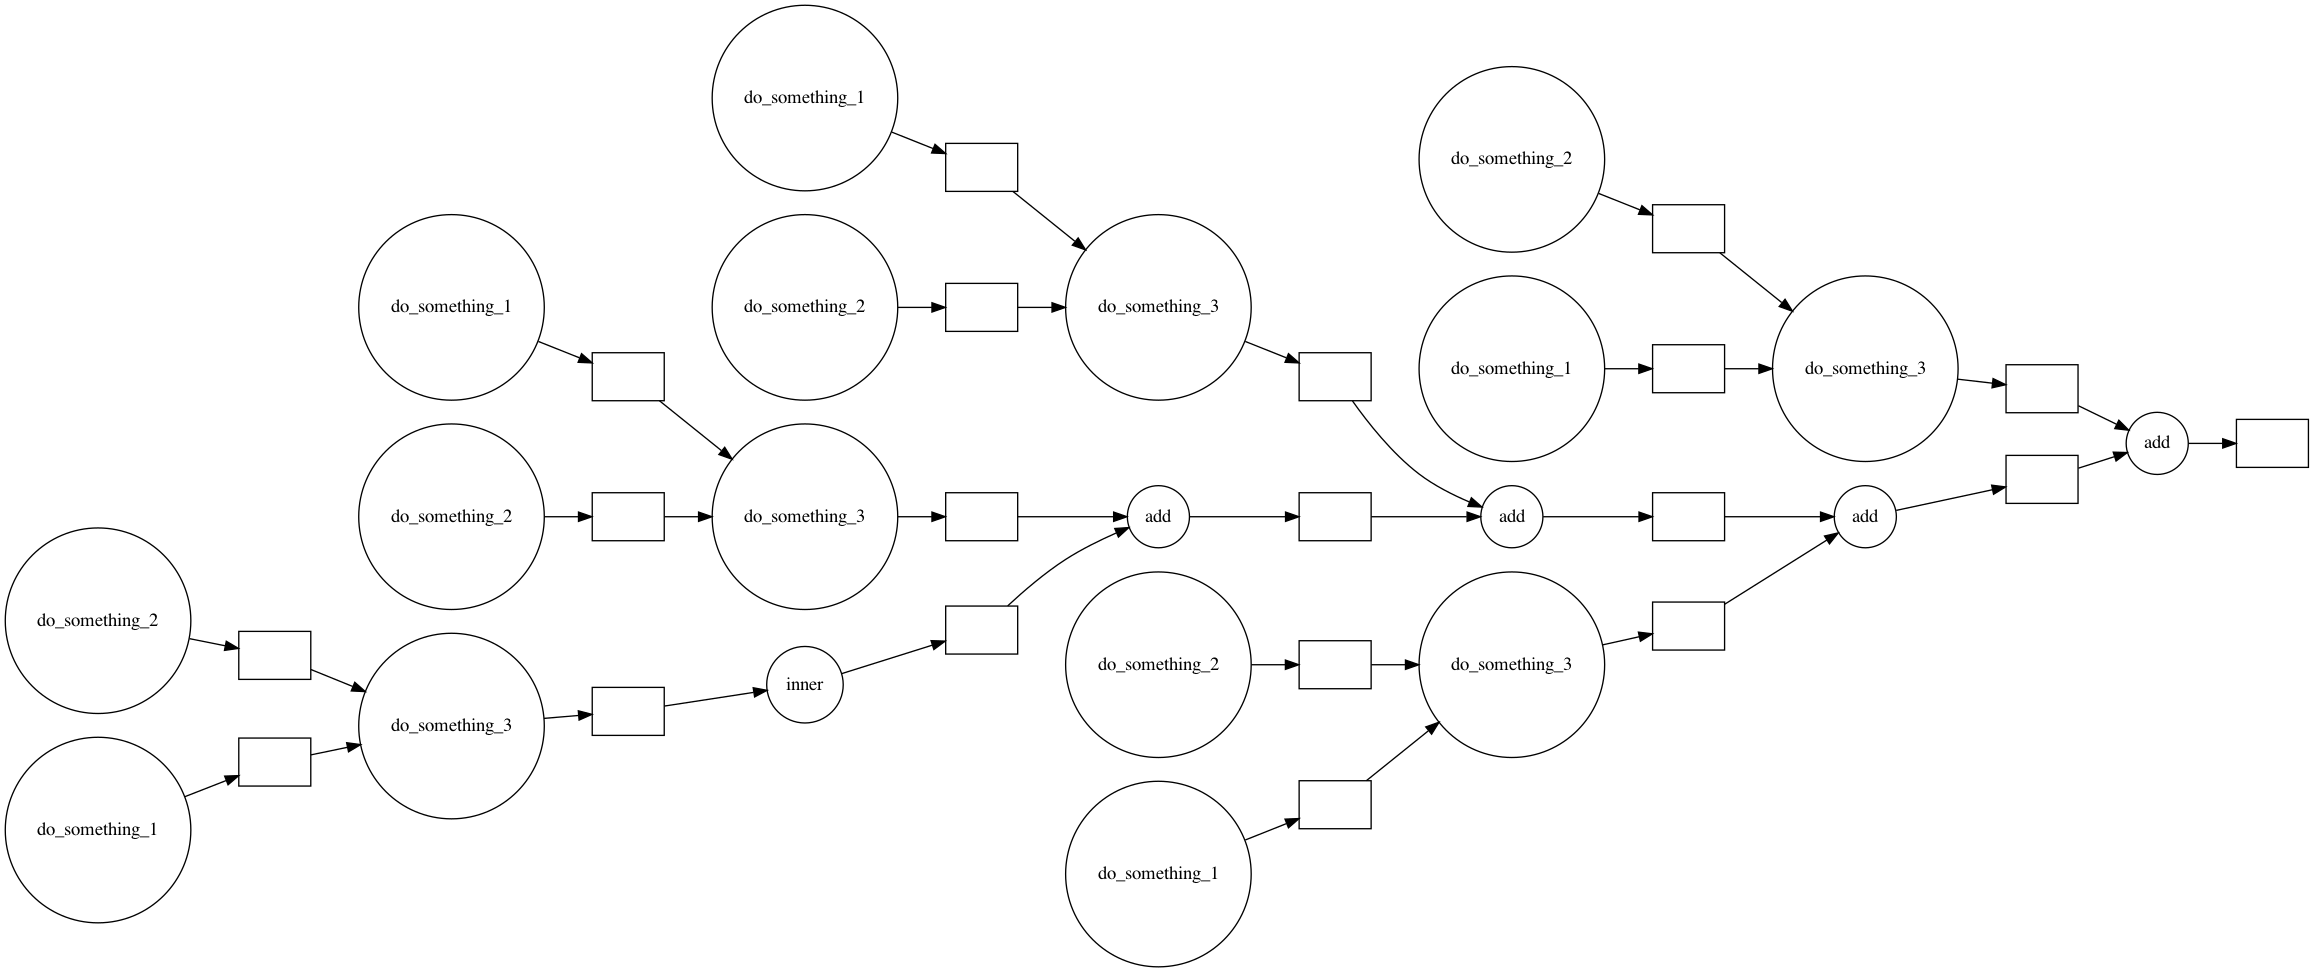

In [174]:
final_sum.visualize(rankdir='LR')

### 將結果也delay

In [175]:
final_result = []
for i in range(0, len(x)):
    res_1 = do_something_1(x[i], y[i])
    res_2 = do_something_2(y[i], z[i])
    res_3 = do_something_3(res_1, res_2)
    final_result.append(res_3)

final_sum = delayed(sum)(final_result)

In [176]:
%time final_sum.compute()

CPU times: user 3.48 ms, sys: 2.83 ms, total: 6.31 ms
Wall time: 2.01 s


19422314786

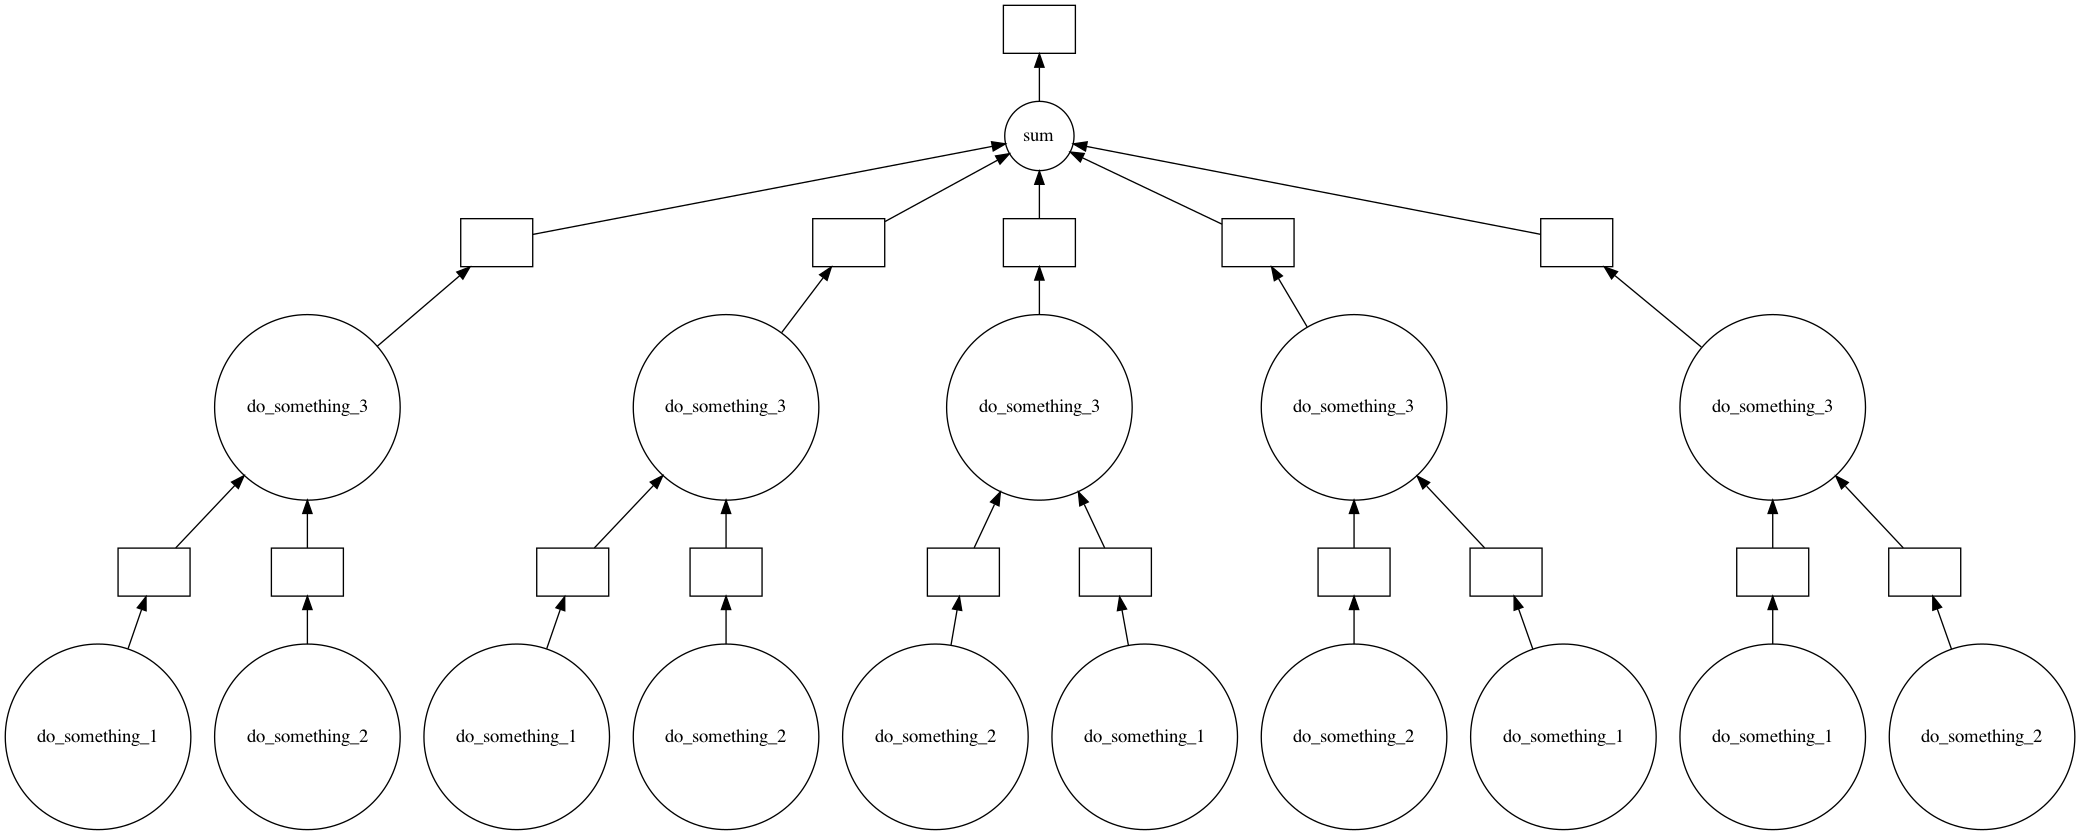

In [177]:
sum_arr.visualize()

# 分散式運算

In [1]:
x = list(range(2, 20000, 2))
y = list(range(3, 30000, 3))
z = list(range(5, 50000, 5))

In [8]:
import dask
from dask import delayed

In [180]:
def do_something_1(x, y):
    return x + y + 2*x*y

def do_something_2(a, b):
    return a**3 - b**3

def do_something_3(p, q):
    return p*p + q*q

In [181]:
final_result = []

for i in range(0, len(x)):
    res_1 = delayed(do_something_1)(x[i], y[i])
    res_2 = delayed(do_something_2)(y[i], z[i])
    res_3 = delayed(do_something_3)(res_1, res_2)
    final_result.append(res_3)
    
final_sum = delayed(sum)(final_result)

In [182]:
with dask.config.set(scheduler='processes'):
    %time _ = final_sum.compute()

CPU times: user 3.93 s, sys: 710 ms, total: 4.64 s
Wall time: 4.28 s


In [183]:
with dask.config.set(scheduler='sync'):
    %time _ = final_sum.compute()

CPU times: user 964 ms, sys: 19.2 ms, total: 983 ms
Wall time: 983 ms


In [184]:
with dask.config.set(scheduler='threading'):
    %time _ = final_sum.compute()

CPU times: user 1.49 s, sys: 173 ms, total: 1.66 s
Wall time: 1.56 s


In [4]:
x = [2, 4, 6, 8]
y = [3, 6, 9, 12]
z = [5, 10, 15, 20]

final_result = []

In [5]:
from time import sleep

def do_something_1(x, y):
    sleep(4)
    return x + y + 2*x*y

def do_something_2(a, b):
    sleep(4)
    return a**3 - b**3

def do_something_3(p, q):
    sleep(4)
    return p*p + q*q

In [6]:
final_result = []
for i in range(0, len(x)):
    res_1 = delayed(do_something_1)(x[i], y[i])
    res_2 = delayed(do_something_2)(y[i], z[i])
    res_3 = delayed(do_something_3)(res_1, res_2)
    final_result.append(res_3)

final_sum = delayed(sum)(final_result)

In [9]:
with dask.config.set(scheduler='processes'):
    %time _ = final_sum.compute()

CPU times: user 31.4 ms, sys: 43.7 ms, total: 75.1 ms
Wall time: 8.37 s


In [11]:
with dask.config.set(scheduler='sync'):
    %time _ = final_sum.compute()

CPU times: user 3.32 ms, sys: 1.92 ms, total: 5.24 ms
Wall time: 48 s


In [190]:
with dask.config.set(scheduler='threading'):
    %time _ = final_sum.compute()

CPU times: user 3.23 ms, sys: 2.3 ms, total: 5.53 ms
Wall time: 8.01 s


In [13]:
from dask.distributed import Client
import dask.dataframe as df

client = Client(processes = False, threads_per_worker = 2, n_workers = 3, memory_limit = '4GB')

client

Client Scheduler: inproc://172.20.10.10/25561/1 Dashboard: http://172.20.10.10:8787/status,Cluster Workers: 3 Cores: 6 Memory: 12.00 GB


In [14]:
import dask.array as da
x = da.random.random((10000, 10000, 10),chunks=(1000, 1000, 5))
y = da.random.random((10000, 10000, 10),chunks=(1000, 1000, 5))
z = (da.arcsin(x) + da.arccos(y)).sum()
z.compute()

1570802503.9892905

# Mini Homework
## 使用 Dask-ml 分類

In [ ]:
from dask_ml.cluster import KMeans
import dask_ml.datasets #pip install dask-ml

## 以Kmeans做

In [ ]:
X, y= dask_ml.datasets.make_blobs()  #在dataset中取500000筆資料,一塊為50000筆資料,random state=0,分成五種資料

In [ ]:
#請KMeans分成五類
#開始訓練

## 找出前十筆資料的分類

In [ ]:
#找出前十筆資料分類
#切記因為dask是lazy evaluation,所以要加compute來顯示結果